### 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

In [1]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
df = load_digits()

In [3]:
kmeans = KMeans(n_clusters=10)

In [4]:
clusters = kmeans.fit_predict(df.data)

In [5]:
centers = kmeans.cluster_centers_.reshape(10,8,8)

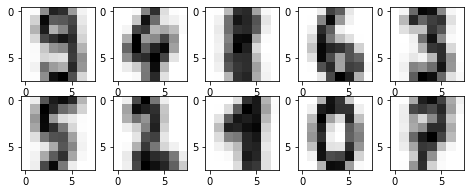

In [6]:
#1.1
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
for axi, center in zip(ax.flat, centers):
    axi.imshow(center,cmap=plt.cm.binary)

In [7]:
#1.2
import numpy as np
from scipy.stats import mode
lst = np.zeros(1797)

for i in range(0,10):
    binary = clusters == i
    lst[binary] = mode(df.target[binary])[0]

print(list(lst)[0:20],list(df.target)[0:20])

[0.0, 8.0, 8.0, 3.0, 4.0, 9.0, 6.0, 7.0, 9.0, 9.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fowlkes_mallows_score

In [9]:
#1.3
accuracy_score(df.target, lst)

0.7924318308291597

In [10]:
#1.3
confusion_matrix(df.target, lst)

array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,  55,  24,   1,   0,   1,   2,   0,  99,   0],
       [  1,   2, 148,  13,   0,   0,   0,   3,   8,   2],
       [  0,   0,   0, 154,   0,   2,   0,   7,   7,  13],
       [  0,   7,   0,   0, 162,   0,   0,   8,   4,   0],
       [  0,   0,   0,   0,   2, 136,   1,   0,   0,  43],
       [  1,   1,   0,   0,   0,   0, 177,   0,   2,   0],
       [  0,   0,   0,   0,   0,   1,   0, 176,   2,   0],
       [  0,   6,   3,   2,   0,   6,   2,   3, 100,  52],
       [  0,  20,   0,   6,   0,   6,   0,   7,   2, 139]], dtype=int64)

In [11]:
#1.4
fowlkes_mallows_score(df.target, lst)

0.7010394732469907

1.4. The diagonal line on the confusion matrix shows the predicted label is equal to the true label. The accuracy score is 0.79577 while Folwes Mallows score presents 0.70512. Accuracy score means how well the predicted value is able to match the true label while Folwes Mallows scores how similar the clusters are. 

### 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

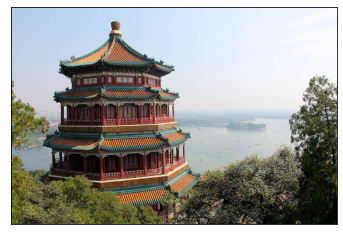

In [12]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [13]:
lst = [2,4,8,16,32,64,128,256,512,1024]

In [14]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [15]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

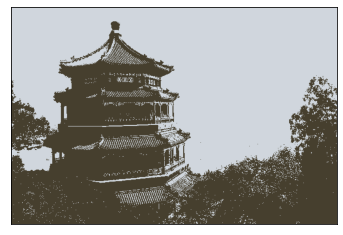

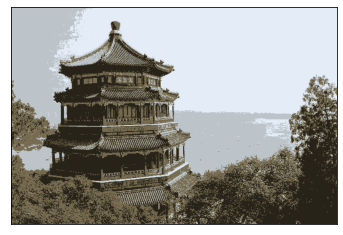

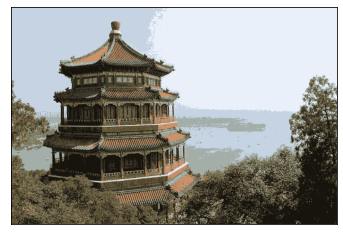

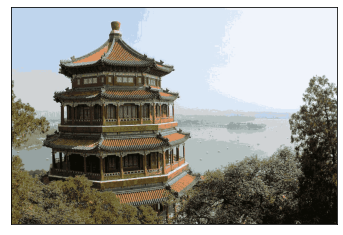

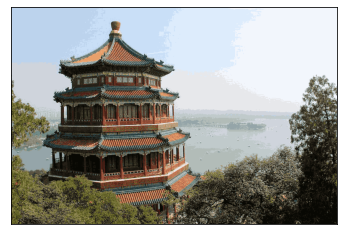

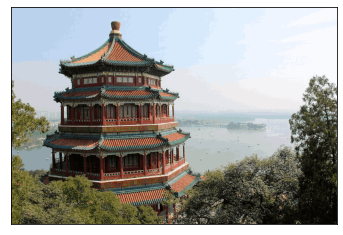

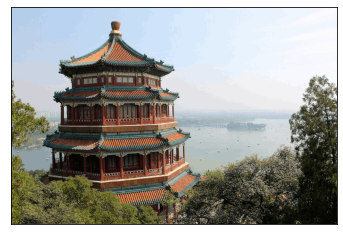

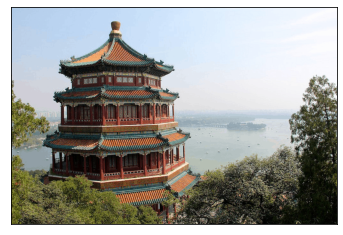

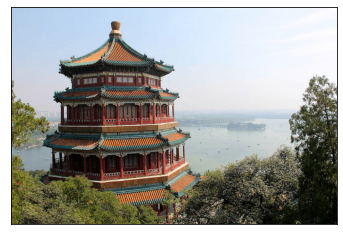

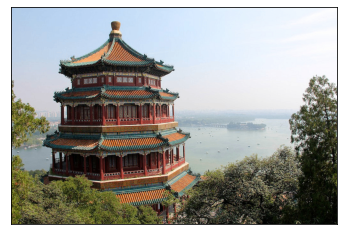

In [16]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans

for n in lst:
    kmeans = MiniBatchKMeans(n)
    kmeans.fit(data)
    new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
    #plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")
    
    image_colour = new_colors.reshape(china.shape)
    #plt.subplot(131)
    ax = plt.axes(xticks=[], yticks=[])
    ax.imshow(image_colour)
    plt.show()

Text(0.5, 1.0, 'Original Image')

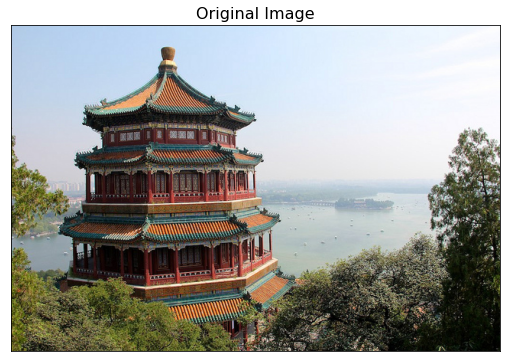

In [17]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax.imshow(china)
ax.set_title('Original Image', size=16)

Above shows 8 pictures, the best image compression picture is the 128 colour vector. The 2, 4 and 8 are almost black and white, it's not visually distingushable. 256,512,1024 are considered high resolution. For 16, 32 & 64 you can see the colour change in the sky so the image is not there yet. 128 and 256 look very similar that an average person cannot tell the difference.

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private of not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.

2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [20]:
college = pd.read_csv('data/college.csv',index_col=0)
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


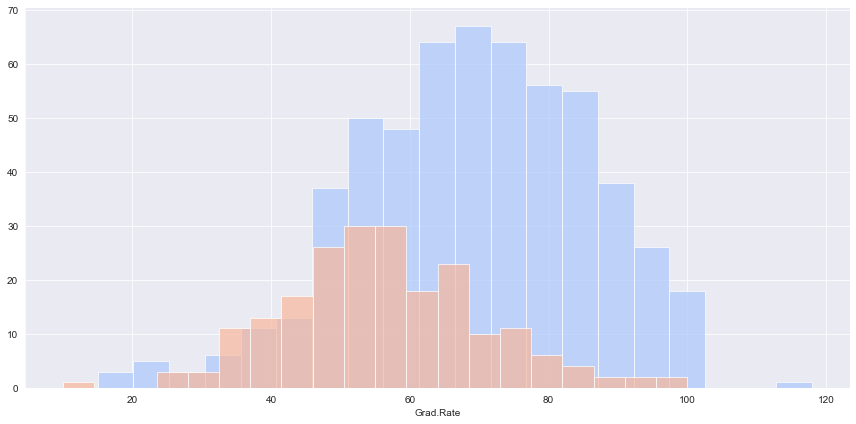

In [21]:
sns.set_style('darkgrid')
g = sns.FacetGrid(college,hue="Private",palette='coolwarm',size=6,aspect=2)
g = g.map(plt.hist,'Grad.Rate',bins=20,alpha=0.7)

In [22]:
college[college['Grad.Rate'] > 100]
college['Grad.Rate']['Cazenovia College'] = 100

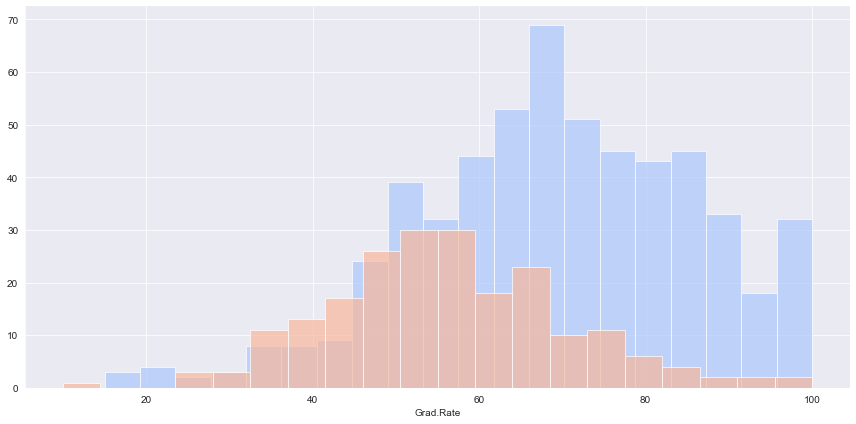

In [23]:
sns.set_style('darkgrid')
g = sns.FacetGrid(college,hue="Private",palette='coolwarm',size=6,aspect=2)
g = g.map(plt.hist,'Grad.Rate',bins=20,alpha=0.7)

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix

In [25]:
kmeans = KMeans(n_clusters=2)
kmeans1 = KMeans(n_clusters=4)

In [26]:
kmeans.fit(college.drop('Private',axis=1))
kmeans1.fit(college.drop('Private',axis=1))

KMeans(n_clusters=4)

In [27]:
def converter(private):
    if private=='Yes':
        return 1
    else:
        return 0

In [28]:
college['Cluster'] = college['Private'].apply(converter)

In [29]:
confusion_matrix(college['Cluster'],kmeans.labels_)

array([[138,  74],
       [531,  34]], dtype=int64)

In [30]:
print(confusion_matrix(college['Cluster'],kmeans.labels_))
#print(confusion_matrix(college['Cluster'],kmeans1.labels_))
print(classification_report(college['Cluster'],kmeans.labels_))
print(classification_report(college['Cluster'],kmeans1.labels_))

[[138  74]
 [531  34]]
              precision    recall  f1-score   support

           0       0.21      0.65      0.31       212
           1       0.31      0.06      0.10       565

    accuracy                           0.22       777
   macro avg       0.26      0.36      0.21       777
weighted avg       0.29      0.22      0.16       777

              precision    recall  f1-score   support

           0       0.29      0.63      0.39       212
           1       0.99      0.36      0.53       565
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.44       777
   macro avg       0.32      0.25      0.23       777
weighted avg       0.80      0.44      0.49       777



In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
features = college.drop('Private',axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [33]:
sse=[]

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k).fit(scaled_features)
    #kmeans.fit(features)
    sse.append(kmeans.inertia_)

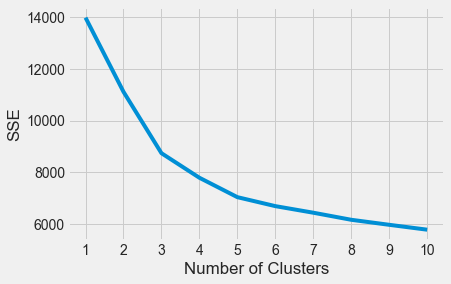

In [34]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [35]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
    )

kl.elbow

4

In [36]:
 model = KMeans()

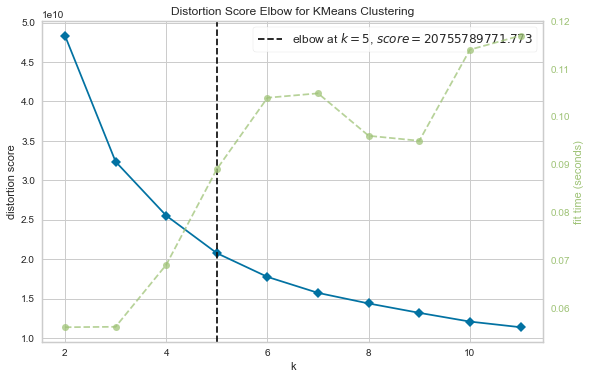

In [37]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(features)
visualizer.show()

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [39]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features, cluster_labels)


For n_clusters = 2 The average silhouette_score is : 0.5599267967411348
For n_clusters = 3 The average silhouette_score is : 0.47593569610929953
For n_clusters = 4 The average silhouette_score is : 0.38208023982193934
For n_clusters = 5 The average silhouette_score is : 0.3874067408045753
For n_clusters = 6 The average silhouette_score is : 0.3081792022352887
For n_clusters = 7 The average silhouette_score is : 0.3067337037679692
For n_clusters = 8 The average silhouette_score is : 0.29766355379165677
For n_clusters = 9 The average silhouette_score is : 0.2735739438906132
For n_clusters = 10 The average silhouette_score is : 0.27437262265309653
For n_clusters = 11 The average silhouette_score is : 0.2721686001808713


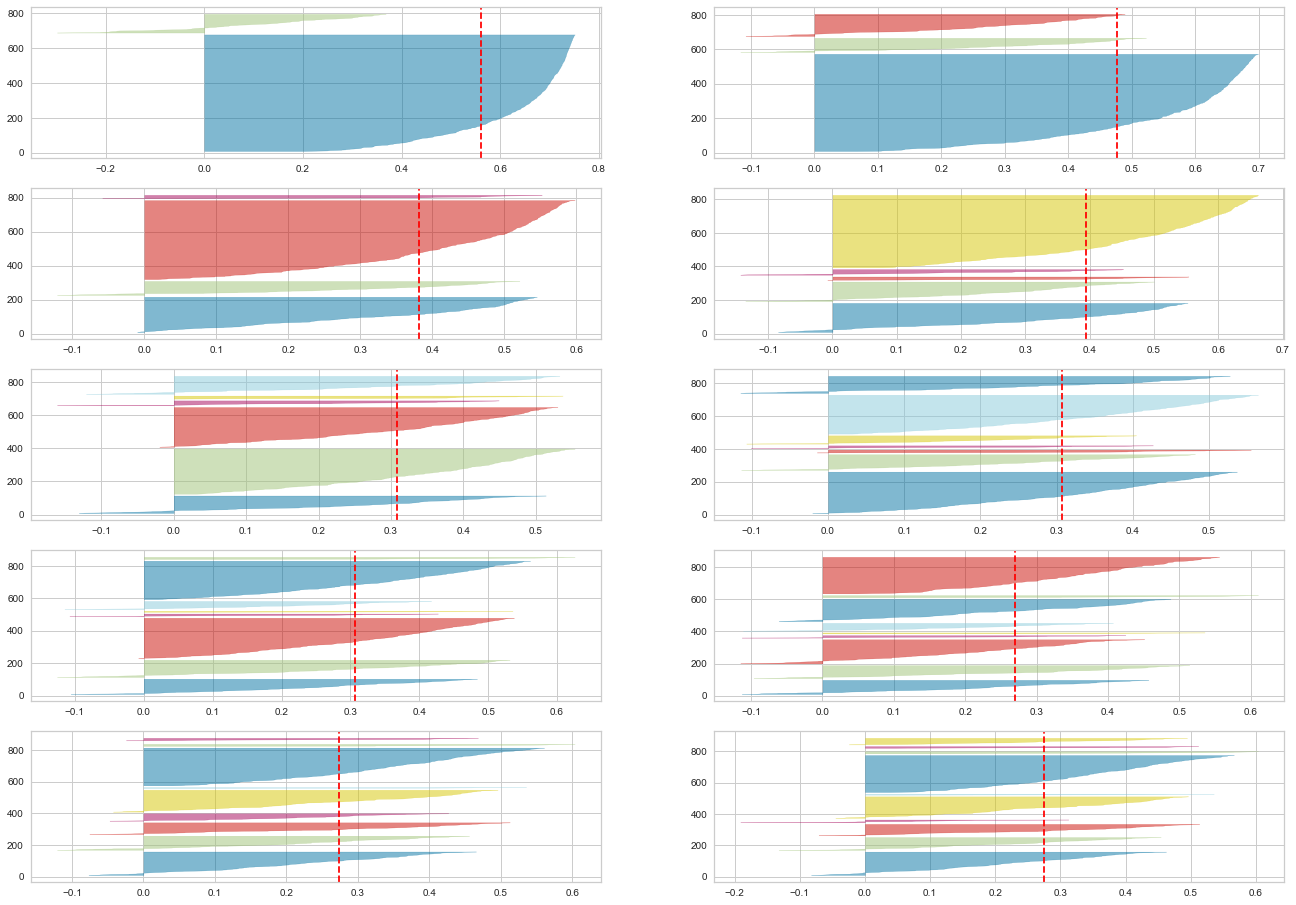

In [40]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(5, 2, figsize=(20,15))
for i in range_n_clusters:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(features)

In [41]:
from sklearn.decomposition import PCA

# pca = PCA(n_components=2).fit(features)
pca = PCA(n_components=2).fit_transform(features)

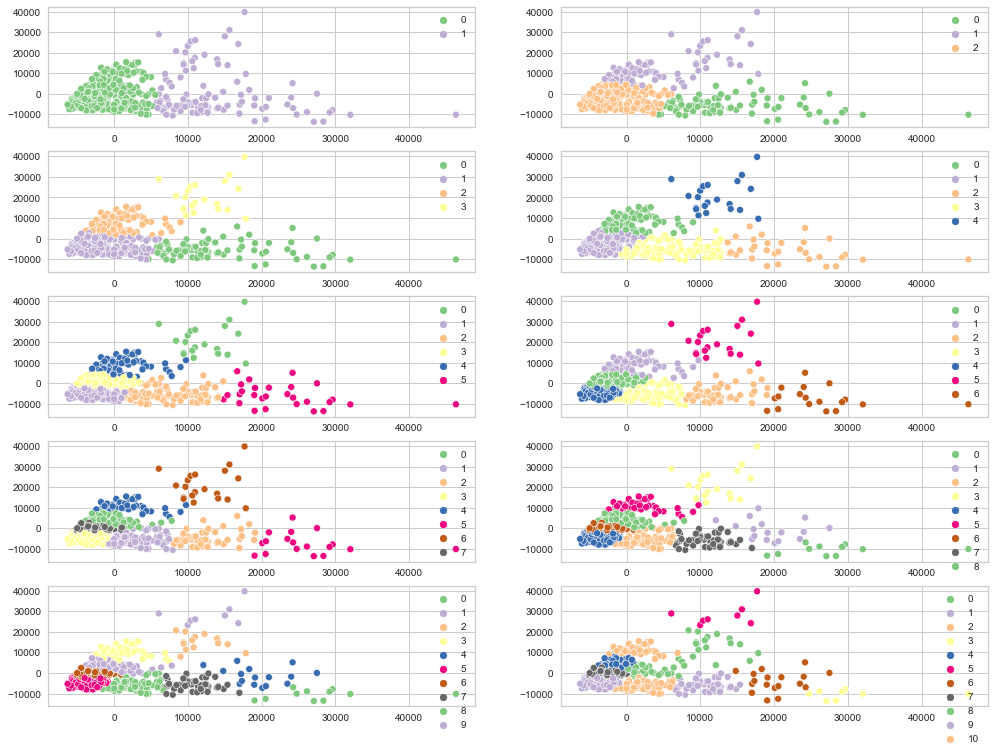

In [42]:
import seaborn as sns
fig,ax = plt.subplots(5, 2, figsize=(15,12))
for i in range_n_clusters:
    q, mod = divmod(i, 2)
    cluster = KMeans(n_clusters=i)
    cluster_label = cluster.fit_predict(pca)
    sns.scatterplot(pca[:,0],pca[:,1],hue=cluster_label,ax=ax[q-1][mod],palette="Accent")
    

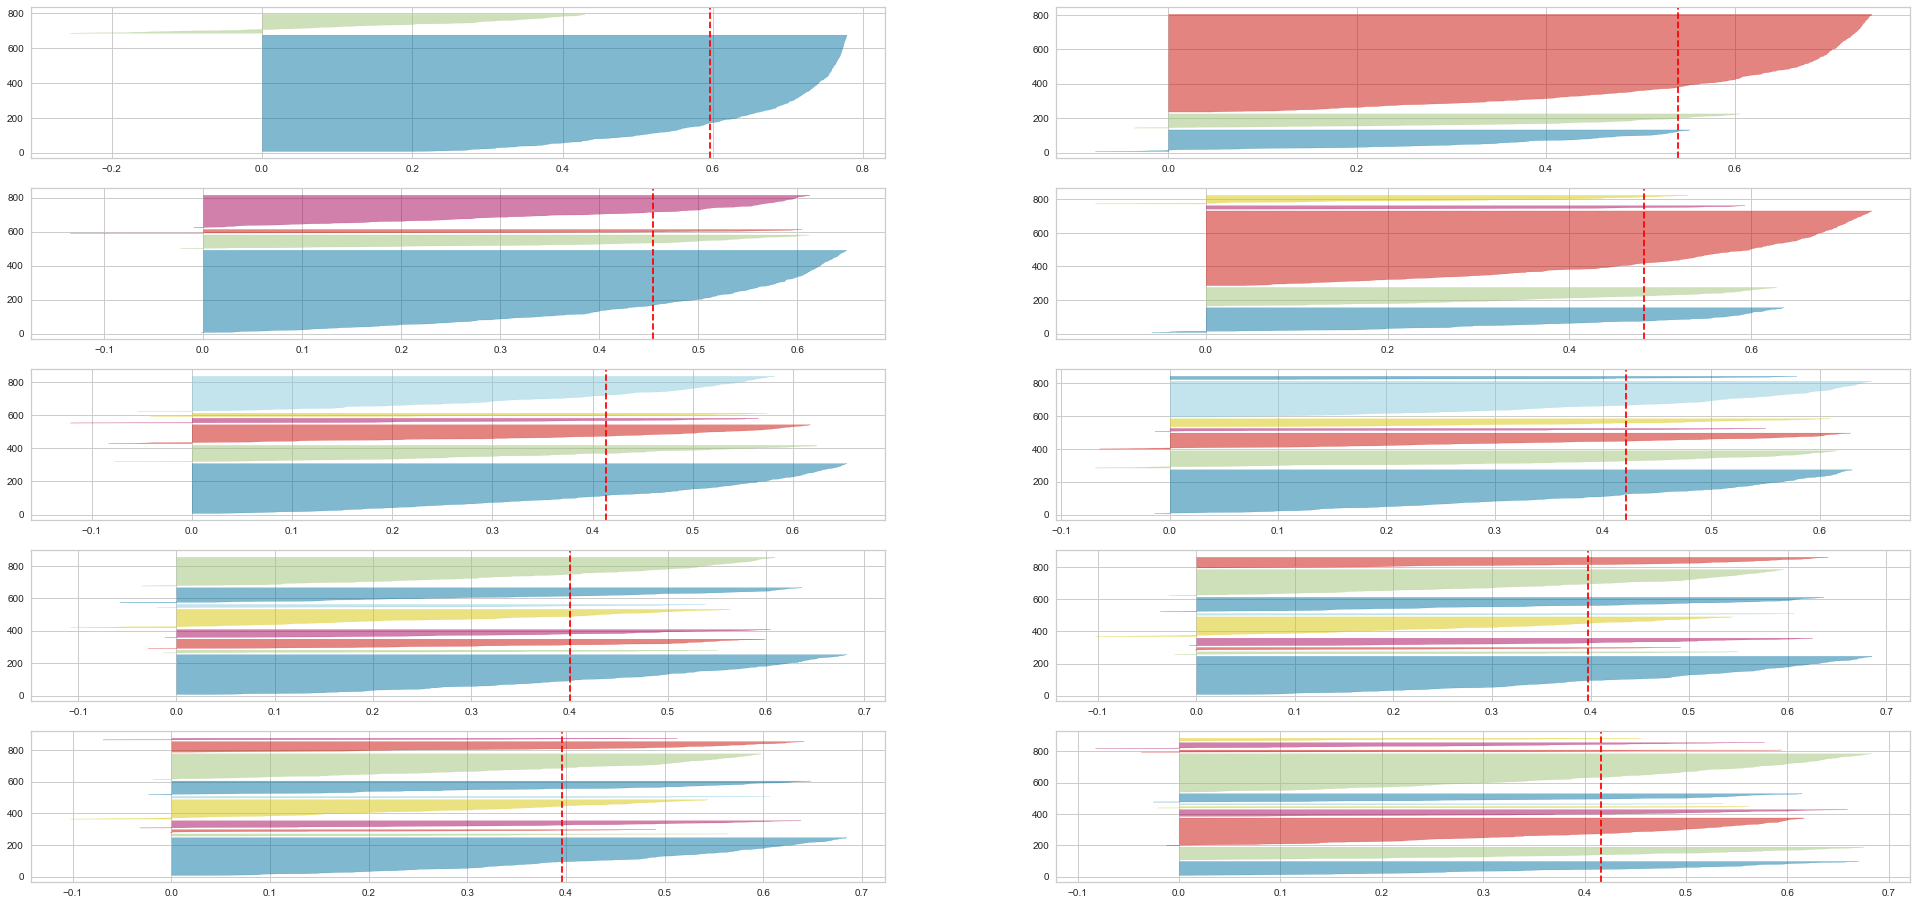

In [43]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(5, 2, figsize=(30,15))
for i in range_n_clusters:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pca)

After doing some research, the Elbow method is best used to identify the optimal number of clusters. To find the optimal number of clusters, I used KneeLocator and KElbowVisualizer. Both libraries gave 4 as the best optimal cluster. I original wanted 4 as my answer. After speaking to Jay (TA),  3 or 5 is more optimal because of its "sharp" point. After doing further research and discussing with Mike Stein, silhouette is a much better method than elbow method. However, silhouette is more difficult to interpret. If the thickness of the model were more uniform, then that model would have the most optimal cluster. That is not happening in this case as I looped over from 2 to 11. After considering the results from the elbow, the scatter plot, histogram(not shown) and silhouette, the best number of cluster is 6. I chose 6  because the thickness that is shown on the silhouette, where number of cluster is equal to 2, 3, 4 and 5 is no longer as apparent. The KElbowVisualizer also shows when the scoring parameter metric is set to distortion and the peak at 6. 